**ライブラリのインポート**

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer  
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
import numpy as np
import time


/tmp/ipykernel_21800/1220730846.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. データの読み込みと簡単な解析

In [2]:
data = pd.read_csv("/workspace/github_repo/data/twlo_prices.csv")
data.head()

,close,volume,date
0,99.98,93417.0,2020-01-02 14:30:00+00:00
1,99.78,16685.0,2020-01-02 14:31:00+00:00
2,100.14,21998.0,2020-01-02 14:32:00+00:00
3,100.35,18348.0,2020-01-02 14:33:00+00:00
4,100.55,22181.0,2020-01-02 14:34:00+00:00


データフレームのindexをdate(太平洋標準時)になるように設定

In [3]:
data.index = pd.to_datetime(data['date']) 
data.index = data.index.tz_convert('US/Pacific') 
data.sort_index(inplace=True) 
del data['date'] 
data.head()

,close,volume
date,,
2020-01-02 06:30:00-08:00,99.98,93417.0
2020-01-02 06:31:00-08:00,99.78,16685.0
2020-01-02 06:32:00-08:00,100.14,21998.0
2020-01-02 06:33:00-08:00,100.35,18348.0
2020-01-02 06:34:00-08:00,100.55,22181.0


In [4]:
data.describe()

,close,volume
count,146502.000000,1.465020e+05
mean,258.653090,7.134329e+03
std,101.456744,1.268060e+04
min,68.245000,0.000000e+00
25%,188.960000,2.192000e+03
50%,273.382500,4.104000e+03
75%,344.358742,7.847000e+03
max,454.960000,1.248549e+06


<Axes: xlabel='date'>

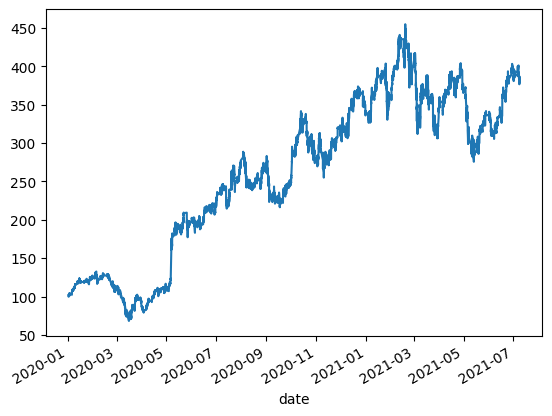

In [5]:
data['close'].plot()

応答変数(目的変数)などの追加

In [6]:
last_price_of_the_day = data.groupby(data.index.date).tail(1)['close'].rename('day_close_price')
last_price_of_the_day.index = last_price_of_the_day.index.date #終日の終値を追加
data['day'] = data.index.date  #日にちを新しい列として追加
data = data.merge(last_price_of_the_day, left_on='day', right_index=True)
data['pct_change_eod'] = (data['day_close_price'] - data['close']) / data['close'] #現在の価格からその日の終値までの変化率を計算
data['stock_price_rose'] = data['pct_change_eod'] > 0  #変化率が正ならばtrue, そうでなければfalseを追加

data.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose
date,,,,,,
2020-01-02 06:30:00-08:00,99.98,93417.0,2020-01-02,103.15,0.031706,True
2020-01-02 06:31:00-08:00,99.78,16685.0,2020-01-02,103.15,0.033774,True
2020-01-02 06:32:00-08:00,100.14,21998.0,2020-01-02,103.15,0.030058,True
2020-01-02 06:33:00-08:00,100.35,18348.0,2020-01-02,103.15,0.027902,True
2020-01-02 06:34:00-08:00,100.55,22181.0,2020-01-02,103.15,0.025858,True


## 2. 特徴量の作成

日付・時刻特徴量の追加

Text(0.5, 0, 'Day of the Week')

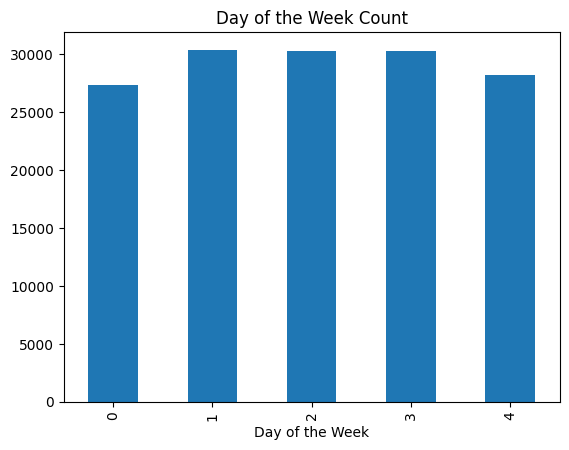

In [7]:
data['feature__dayofweek'] = data.index.dayofweek  #曜日を表す5値
data['feature__morning'] = data.index.hour < 12  #午前か午後かの2値

data['feature__dayofweek'].value_counts().sort_index().plot(kind='bar', title='Day of the Week Count')
plt.xlabel('Day of the Week')

Text(0.5, 0, 'Is Morning')

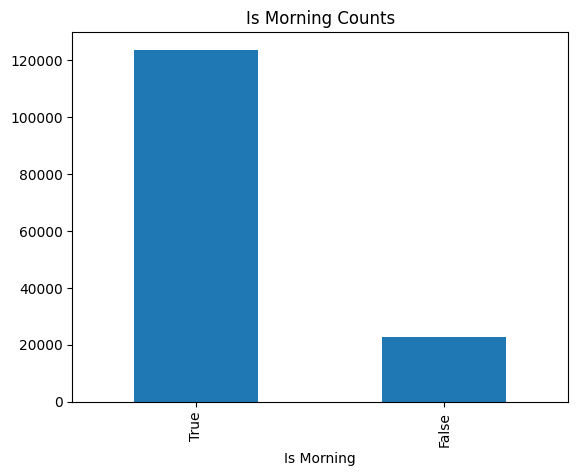

In [8]:
data['feature__morning'].value_counts().plot(kind='bar', title='Is Morning Counts')
plt.xlabel('Is Morning')

ラグ特徴量の追加

/tmp/ipykernel_411/1342357975.py:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  data['feature__lag_30_min_ago_price'] = data['close'].shift(30, freq='T') #30分前の株価


Text(0, 0.5, 'Price')

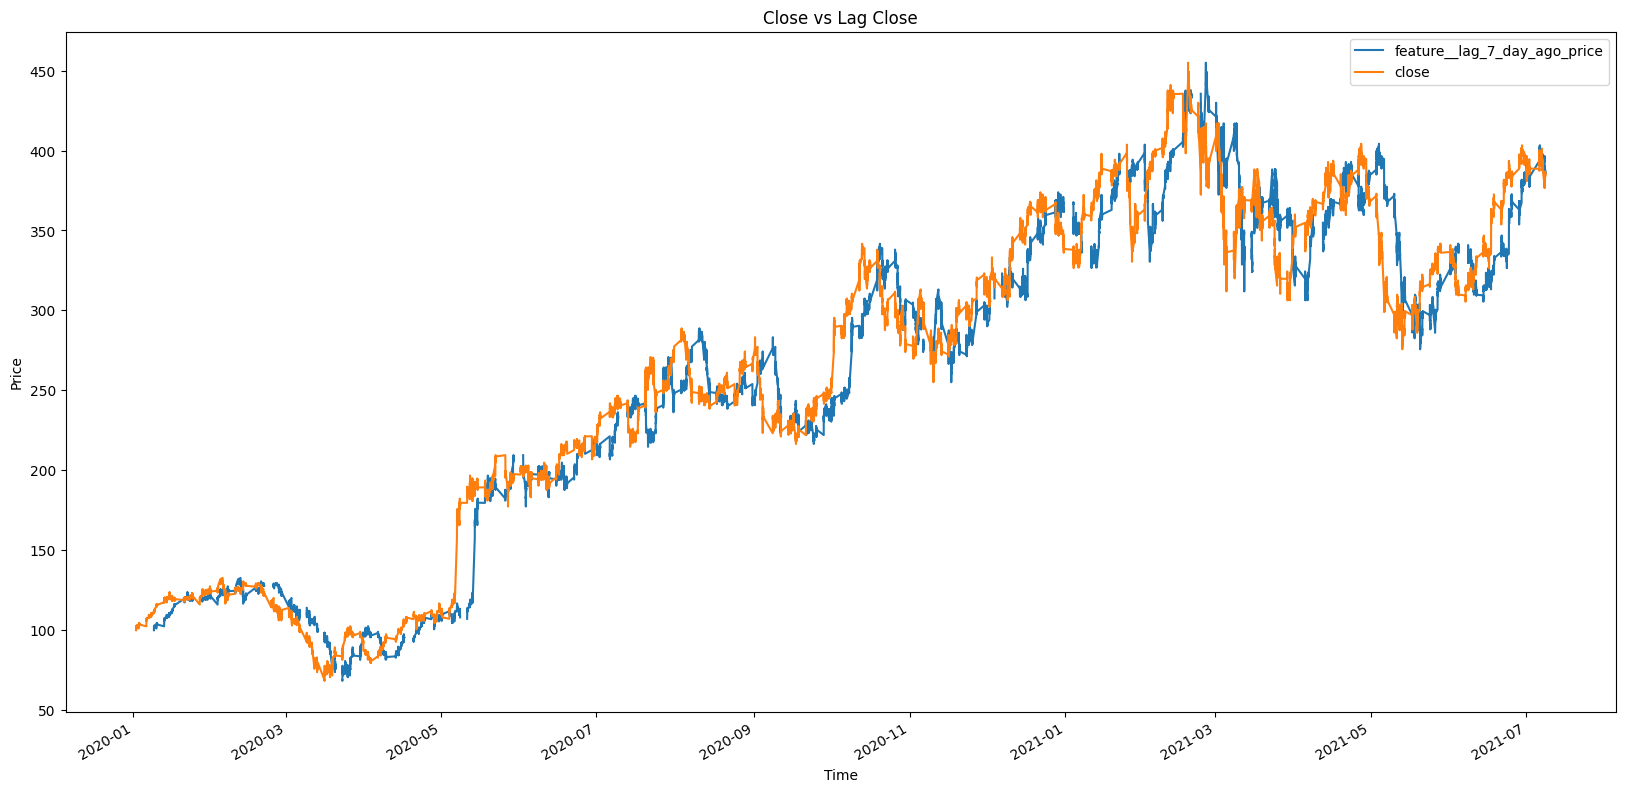

In [9]:
data['feature__lag_30_min_ago_price'] = data['close'].shift(30, freq='T') #30分前の株価
data['feature__lag_7_day_ago_price'] = data['close'].shift(7, freq='D') #7日前の株価

#7日前の株価についてプロット
data['feature__lag_7_day_ago_price'].plot(figsize=(20,10), title='Close vs Lag Close')
data['close'].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Price')

ローリング特徴量の追加

Text(0, 0.5, 'Price')

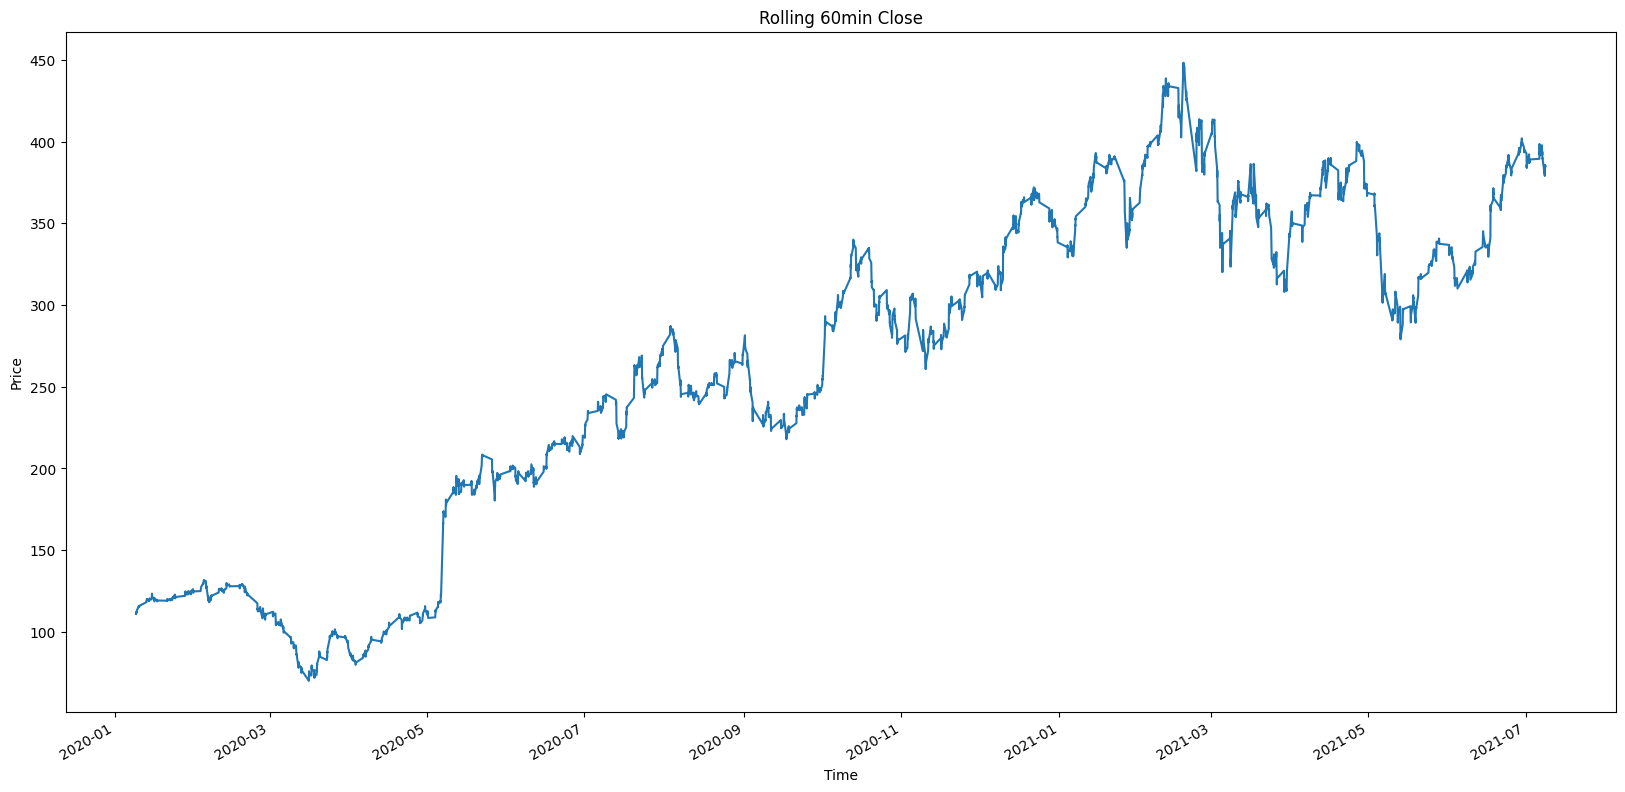

In [10]:
data['feature__rolling_close_mean_60'] = data['close'].rolling('60min').mean() #過去60分間のローリング平均
data['feature__rolling_close_std_60'] = data['close'].rolling('60min').std() #過去60分間のローリング標準偏差
data['feature__rolling_volume_mean_60'] = data['volume'].rolling('60min').mean() #過去60分間の出来高(取引量のこと)のローリング平均
data['feature__rolling_volume_std_60'] = data['volume'].rolling('60min').std() #過去60分間の出来高のローリング標準偏差

data.dropna(inplace=True)

#終値のローリング平均についてプロット
data['feature__rolling_close_mean_60'].plot(figsize=(20, 10), title='Rolling 60min Close')
plt.xlabel('Time')
plt.ylabel('Price')

エクスパンディング特徴量の追加

Text(0, 0.5, 'Price')

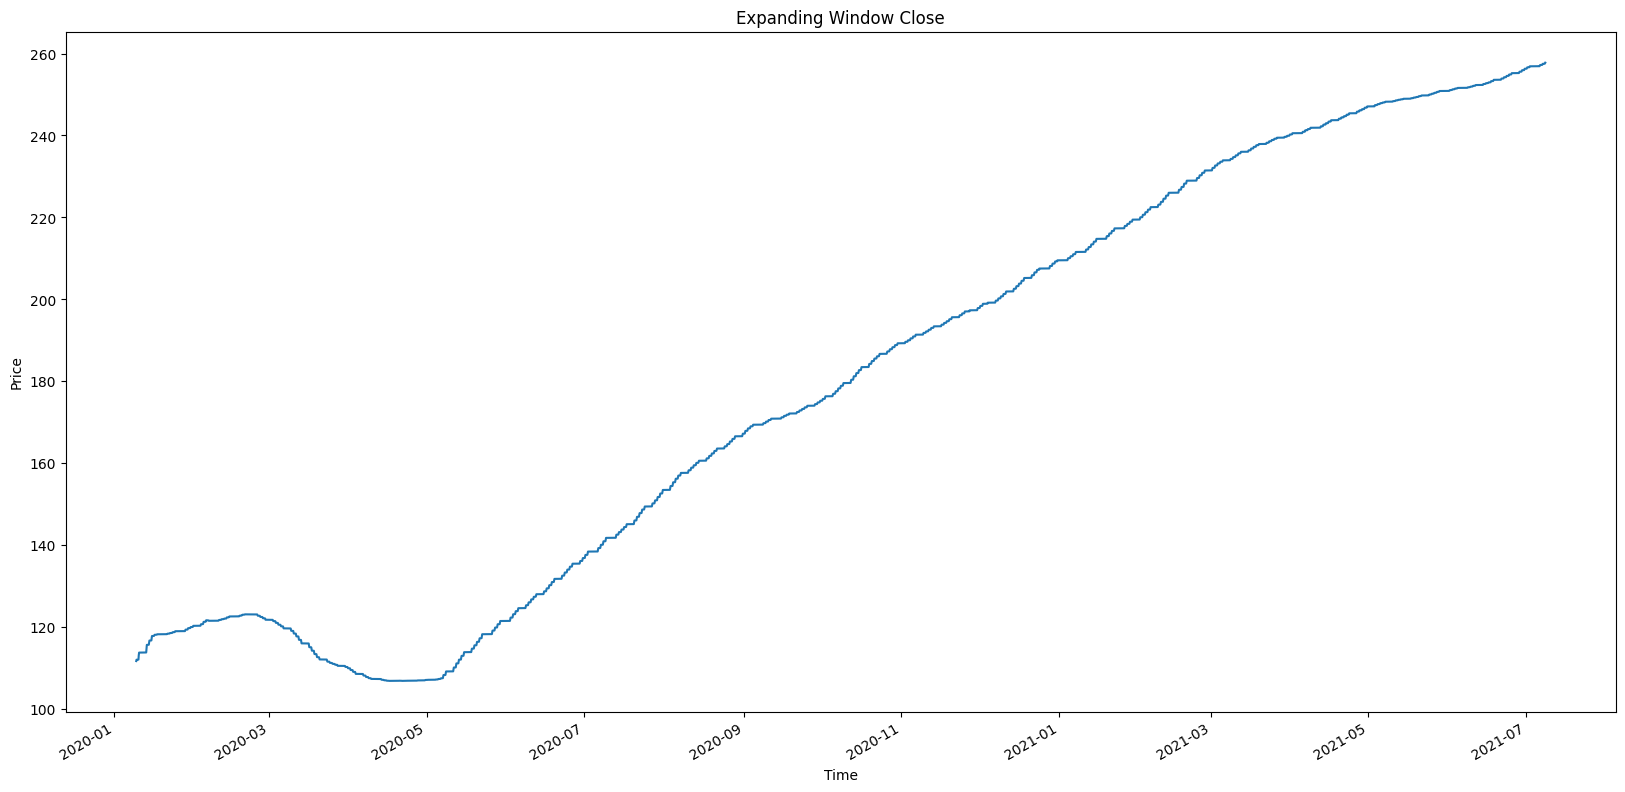

In [11]:
data['feature__expanding_close_mean'] = data['close'].expanding(200).mean() #終値のエクスパンディング平均
data['feature__expanding_volume_mean'] = data['volume'].expanding(200).mean() #出来高のエクスパンディング平均
#どちらもエクスパンディング平均の計算に必要な最小時間を200分に設定している
data.dropna(inplace=True)

#終値のエクスパンディング平均をプロット
data['feature__expanding_close_mean'].plot(figsize=(20, 10), title='Expanding Window Close')
plt.xlabel('Time')
plt.ylabel('Price')

## 3. ベースラインモデルの学習

学習に用いる各種関数等の宣言

In [12]:
#ランダムフォレストのグリッドサーチ関数(下)に渡す引数の宣言
tscv = TimeSeriesSplit(n_splits=5)  #5個のブロックに分割して時系列データ専用の交差検証を行えるインスタンス
clf = RandomForestClassifier(random_state=0) #ランダムフォレストインスタンス
ml_pipeline = Pipeline([ #パイプライン
    ('scale', StandardScaler()),
    ('classifier', clf)
])
params = { #探索するgridsearch用のパラメータ
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 3, 5],
    
    'classifier__max_depth': [10, None],
    'classifier__max_features': [None, 'auto']
}

#ランダムフォレスト用のグリッドサーチ学習関数
def advanced_grid_search(x_train, y_train, x_test, y_test, ml_pipeline, params, cv=3, include_probas=False):
    
    model_grid_search = GridSearchCV(ml_pipeline, param_grid=params, cv=cv, error_score=-1)
    start_time = time.time()
    model_grid_search.fit(x_train, y_train)
    best_model = model_grid_search.best_estimator_
    
    y_preds = best_model.predict(x_test)
    print(classification_report(y_true=y_test, y_pred=y_preds))
    print(f'Best params: {model_grid_search.best_params_}')
    end_time = time.time()
    print(f"Overall took {(end_time - start_time):.2f} seconds")
    
    if include_probas:
        y_probas = best_model.predict_proba(x_test).max(axis=1)
        return best_model, y_preds, y_probas
    
    return best_model, y_preds

#予測結果から損益を計算して表示する関数
def plot_gains(df, response, predictions):
    df['predictions'] =  predictions
    df['movement_correct_multiplier'] = (predictions == response).map({True: 1, False: -1})
    df['gain'] = df['movement_correct_multiplier'] * df['pct_change_eod'].abs()
    
    bullish = df[predictions == True]
    bullish_gains = bullish.sort_index().groupby(bullish.index.date).head(1)['gain']
    bullish_gains.cumsum().plot(label='Bullish Only', legend=True)
    print(f'% of time with profit: {(bullish_gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for bullish is {bullish_gains.sum():.3f}')
    
    bearish = df[predictions == False]
    bearish_gains = bearish.sort_index().groupby(bearish.index.date).head(1)['gain']
    bearish_gains.cumsum().plot(label='Bearish Only', legend=True)
    print(f'% of time with profit: {(bearish_gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for bearish is {bearish_gains.sum():.3f}')
    
    gains = df.sort_index().groupby(df.index.date).head(1)['gain']
    gains.cumsum().plot(label='All Predictions', legend=True)
    print(f'% of time with profit: {(gains.cumsum() > 0).mean():.3f}')
    print(f'Total Gains for all predictions is {gains.sum():.3f}')
    
    plt.title('Gains')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Gains')


時系列データの交差検証について

In [13]:
#先ほど宣言した時系列データ用のスプリットの確認
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    train_times, test_times = data.iloc[train_index].index, data.iloc[test_index].index
    print(f'Iteration {i}\n-------------')
    print(f'''Training between {train_times.min().date()} and {train_times.max().date()}. Testing between {test_times.min().date()} and {test_times.max().date()}\n''')
    

Iteration 0
-------------
Training between 2020-01-09 and 2020-04-06. Testing between 2020-04-06 and 2020-07-01

Iteration 1
-------------
Training between 2020-01-09 and 2020-07-01. Testing between 2020-07-01 and 2020-09-25

Iteration 2
-------------
Training between 2020-01-09 and 2020-09-25. Testing between 2020-09-25 and 2020-12-22

Iteration 3
-------------
Training between 2020-01-09 and 2020-12-22. Testing between 2020-12-22 and 2021-03-30

Iteration 4
-------------
Training between 2020-01-09 and 2021-03-30. Testing between 2021-03-30 and 2021-07-08



学習全体としてのtrain-test分割関数の定義

In [14]:
def split_data(df): #データフレームを受け取り設定した範囲かつ特徴量を選択して分割して返す補助関数
    
    downsized_df = df[(df.index.minute == 0)]  #学習サイズを小さくするために分単位ではなく時間単位でデータを抽出
    train_df, test_df = downsized_df[:'2021-05-31'], downsized_df['2021-06-01':]  #指定した範囲でtrain-testを分割
    train_X, test_X = train_df.filter(regex='feature'), test_df.filter(regex='feature')  #接頭辞「feature」で検索をかけて追加した特徴量のみを抽出
    train_y, test_y = train_df['stock_price_rose'], test_df['stock_price_rose'] #応答変数も従って分割
    return train_df, test_df, train_X, train_y, test_X, test_y


In [15]:
data.head()

,close,volume,day,day_close_price,pct_change_eod,stock_price_rose,feature__dayofweek,feature__morning,feature__lag_30_min_ago_price,feature__lag_7_day_ago_price,feature__rolling_close_mean_60,feature__rolling_close_std_60,feature__rolling_volume_mean_60,feature__rolling_volume_std_60,feature__expanding_close_mean,feature__expanding_volume_mean
date,,,,,,,,,,,,,,,,
2020-01-09 10:20:00-08:00,112.060,10682.0,2020-01-09,113.02,0.008567,True,3,True,111.640,102.015,111.681640,0.249151,8595.333333,8580.837482,111.784582,8977.800000
2020-01-09 10:21:00-08:00,112.000,4219.0,2020-01-09,113.02,0.009107,True,3,True,111.660,102.060,111.679807,0.246335,8537.433333,8598.731168,111.785654,8954.124378
2020-01-09 10:22:00-08:00,111.870,11553.0,2020-01-09,113.02,0.010280,True,3,True,111.560,102.040,111.680140,0.246582,8592.966667,8607.408082,111.786072,8966.990099
2020-01-09 10:23:00-08:00,111.850,2644.0,2020-01-09,113.02,0.010460,True,3,True,111.370,102.060,111.681473,0.247292,8468.050000,8638.919321,111.786387,8935.842365
2020-01-09 10:24:00-08:00,111.825,2250.0,2020-01-09,113.02,0.010686,True,3,True,111.425,102.120,111.682223,0.247663,8464.966667,8641.141813,111.786576,8903.068627


ベースラインモデルの学習実行

In [16]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(data)

print("Date-time/Lag/Window/Rolling features + Random Forest\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True
)
#結果は正答率50%程度と全くよくない

Date-time/Lag/Window/Rolling features + Random Forest


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

              precision    recall  f1-score   support

       False       0.52      0.78      0.62        72
        True       0.52      0.25      0.33        69

    accuracy                           0.52       141
   macro avg       0.52      0.51      0.48       141
weighted avg       0.52      0.52      0.48       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 5}
Overall took 26.02 seconds


% of time with profit: 0.105
Total Gains for bullish is -0.060
% of time with profit: 1.000
Total Gains for bearish is 0.022
% of time with profit: 0.077
Total Gains for all predictions is -0.073


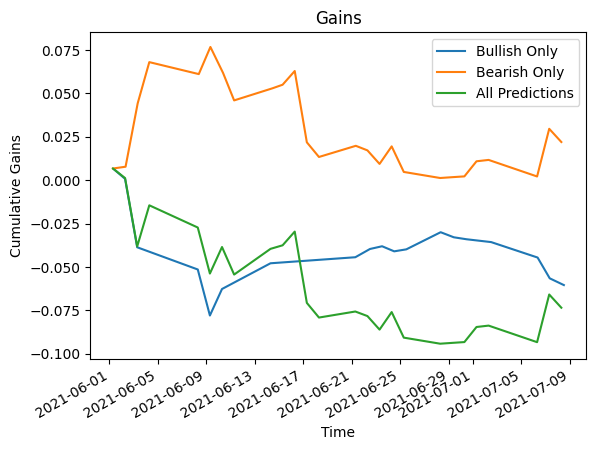

In [17]:
plot_gains(test_df.copy(), test_y, test_preds) #ベースラインモデルに従った場合の損益の図示
#全ての予想に従った場合は「-7.3%の損」となる

## 4. ドメイン固有特徴量の利用

長期的な指標の導入

In [18]:
daily_features = pd.DataFrame() #日にちごとの特徴量を格納するドメイン固有特徴量DF

daily_features['first_5_min_avg_close'] = data.groupby(
    data.index.date
)['close'].apply(lambda x: x.head().mean())  # ある日の開始5分間の平均(始値)
daily_features['last_5_min_avg_close'] = data.groupby(
    data.index.date
)['close'].apply(lambda x: x.tail().mean())  # ある日の終了5分間の平均(終値)


daily_features['feature__overnight_change_close'] = \
    (daily_features['first_5_min_avg_close'] - daily_features['last_5_min_avg_close'].shift(1)) / daily_features['last_5_min_avg_close'].shift(1)
#日にちを跨いだ夜間の変化量

daily_features['feature__monthly_pct_change_close'] = daily_features['first_5_min_avg_close'].pct_change(periods=31)
#始値のローリング変化率(31日基準)

daily_features['feature__expanding_average_close'] = daily_features['first_5_min_avg_close'].expanding(31).mean()  
#始値のエクスパンディング平均(はじめ31日間は省略)


MACD(移動平均収束拡散)の導入

In [19]:
def macd(ticker):  #MACD指標の算出関数
    exp1 = ticker.ewm(span=12, adjust=False).mean()
    exp2 = ticker.ewm(span=26, adjust=False).mean()
    macd = exp1 - exp2
    return macd.ewm(span=9, adjust=False).mean()

daily_features['feature__macd'] = macd(daily_features['first_5_min_avg_close']) #始値を使用してMACDを算出

data = data.merge(daily_features, left_on=data.index.date, right_index=True)  #上で計算した特徴量を結合
data.dropna(inplace=True)

Twitterの活用

In [20]:
tweet_df = pd.read_csv(f"/workspace/github_repo/data/twlo_tweets.csv", encoding='ISO-8859-1')

#同様に日にちをindexに変更
tweet_df.index = pd.to_datetime(tweet_df['date_tweeted'], format='ISO8601')
tweet_df.index = tweet_df.index.tz_convert('US/Pacific')
del tweet_df['date_tweeted']
tweet_df.sort_index(inplace=True)
tweet_df.dropna(inplace=True)

#期間を目的の範囲に設定
tweet_df = tweet_df['2019-12-01':'2021-07-08']

tweet_df.head()

,text,tweet_unique_id,author_verified,num_followers
date_tweeted,,,,
2019-12-01 00:31:34-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201056e+18,False,1557.0
2019-12-01 01:03:56-08:00,Benjamin Graham and the Power of Growth Stocks...,1.201064e+18,False,1150.0
2019-12-01 01:25:16-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201070e+18,False,3887.0
2019-12-01 01:34:11-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201072e+18,False,881.0
2019-12-01 01:55:24-08:00,RT @BrianFeroldi: Tech stocks I follow ranked ...,1.201077e+18,False,6.0


/tmp/ipykernel_411/605997029.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rolling_1_day_verified_count = tweet_df.resample('1T')['author_verified'].sum().rolling('1D').sum()


Text(0, 0.5, 'Number of Verified Tweets')

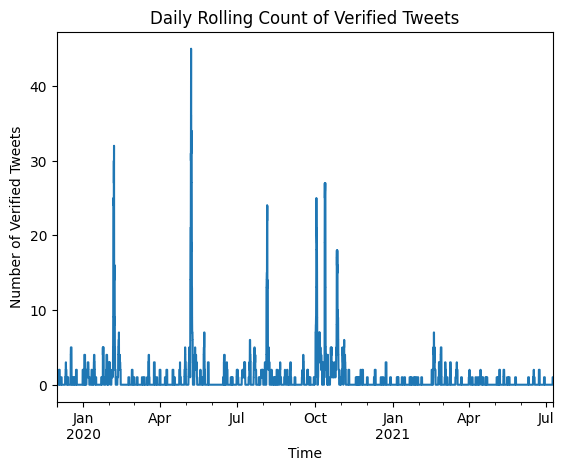

In [21]:
#認証アカウントのみの1日間でのツイート数ローリング合計
rolling_1_day_verified_count = tweet_df.resample('1T')['author_verified'].sum().rolling('1D').sum()

rolling_1_day_verified_count.plot(title='Daily Rolling Count of Verified Tweets')
plt.xlabel('Time')
plt.ylabel('Number of Verified Tweets')

/tmp/ipykernel_411/166789353.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rolling_7_day_total_tweets = tweet_df.resample('1T')['tweet_unique_id'].count().rolling('7D').sum()


Text(0, 0.5, 'Number of Tweets')

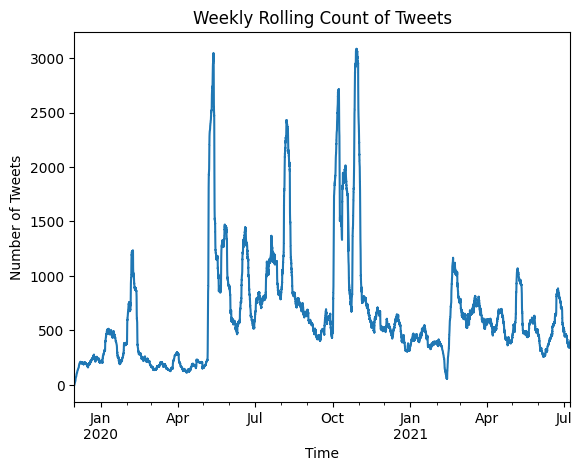

In [22]:
#全アカウントでの7日間ツイート数ローリング合計
rolling_7_day_total_tweets = tweet_df.resample('1T')['tweet_unique_id'].count().rolling('7D').sum()

rolling_7_day_total_tweets.plot(title='Weekly Rolling Count of Tweets')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')

In [23]:
#Twitter特徴量のdataへの結合
twitter_stats = pd.DataFrame({
    'feature__rolling_7_day_total_tweets': rolling_7_day_total_tweets,
    'feature__rolling_1_day_verified_count': rolling_1_day_verified_count
}) 

twitter_stats.index = pd.to_datetime(twitter_stats.index)  #datetime型にindexを明示的に変更し結合できるようにする
twitter_stats.index = twitter_stats.index.tz_convert('US/Pacific')

data = data.merge(twitter_stats, left_index=True, right_index=True)  #dataに結合
data.head()

,key_0,close,volume,day,day_close_price,pct_change_eod,stock_price_rose,feature__dayofweek,feature__morning,feature__lag_30_min_ago_price,...,feature__expanding_close_mean,feature__expanding_volume_mean,first_5_min_avg_close,last_5_min_avg_close,feature__overnight_change_close,feature__monthly_pct_change_close,feature__expanding_average_close,feature__macd,feature__rolling_7_day_total_tweets,feature__rolling_1_day_verified_count
2020-02-27 07:00:00-08:00,2020-02-27,109.47,12463.0,2020-02-27,110.9,0.013063,True,3,True,107.5200,...,122.554386,7602.227133,109.288,111.253,-0.032747,-0.023526,122.206249,1.504137,213.0,0.0
2020-02-27 07:01:00-08:00,2020-02-27,109.36,9357.0,2020-02-27,110.9,0.014082,True,3,True,107.2700,...,122.553196,7602.385406,109.288,111.253,-0.032747,-0.023526,122.206249,1.504137,213.0,0.0
2020-02-27 07:02:00-08:00,2020-02-27,109.24,8758.0,2020-02-27,110.9,0.015196,True,3,True,106.8794,...,122.551996,7602.489628,109.288,111.253,-0.032747,-0.023526,122.206249,1.504137,213.0,0.0
2020-02-27 07:03:00-08:00,2020-02-27,109.25,8050.0,2020-02-27,110.9,0.015103,True,3,True,107.0000,...,122.550796,7602.529985,109.288,111.253,-0.032747,-0.023526,122.206249,1.504137,213.0,0.0
2020-02-27 07:04:00-08:00,2020-02-27,109.12,8398.0,2020-02-27,110.9,0.016312,True,3,True,106.6100,...,122.549585,7602.601713,109.288,111.253,-0.032747,-0.023526,122.206249,1.504137,213.0,0.0


**ドメイン固有特徴量を使用した場合の学習結果と利益の予想値**

Add Domain Features


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/pyth

              precision    recall  f1-score   support

       False       0.46      0.53      0.49        72
        True       0.41      0.35      0.38        69

    accuracy                           0.44       141
   macro avg       0.44      0.44      0.43       141
weighted avg       0.44      0.44      0.44       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5}
Overall took 31.08 seconds
% of time with profit: 0.000
Total Gains for bullish is -0.043
% of time with profit: 0.273
Total Gains for bearish is -0.006
% of time with profit: 0.077
Total Gains for all predictions is -0.069


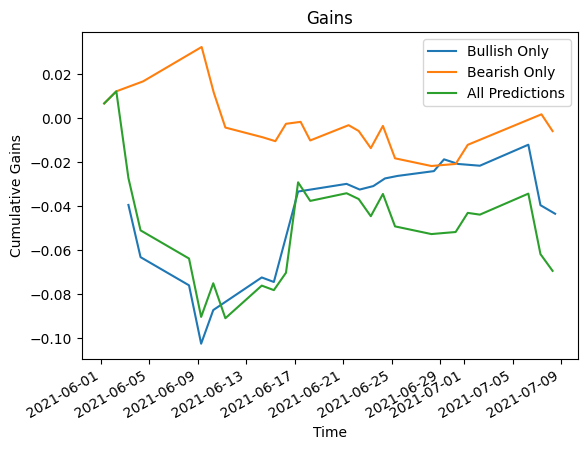

In [24]:
train_df, test_df, train_X, train_y, test_X, test_y = split_data(data)

print("Add Domain Features\n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True
)

plot_gains(test_df.copy(), test_y, test_preds)

## 5. 特徴量選択

SFMによる削減

Feature Selection (SFM) 


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/py

              precision    recall  f1-score   support

       False       0.45      0.42      0.43        72
        True       0.44      0.48      0.46        69

    accuracy                           0.45       141
   macro avg       0.45      0.45      0.45       141
weighted avg       0.45      0.45      0.45       141

Best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': None, 'classifier__min_samples_split': 2, 'select_from_model__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'select_from_model__threshold': '0.5 * mean'}
Overall took 208.62 seconds
% of time with profit: 0.000
Total Gains for bullish is -0.039
% of time with profit: 0.714
Total Gains for bearish is -0.008
% of time with profit: 0.154
Total Gains for all predictions is -0.043


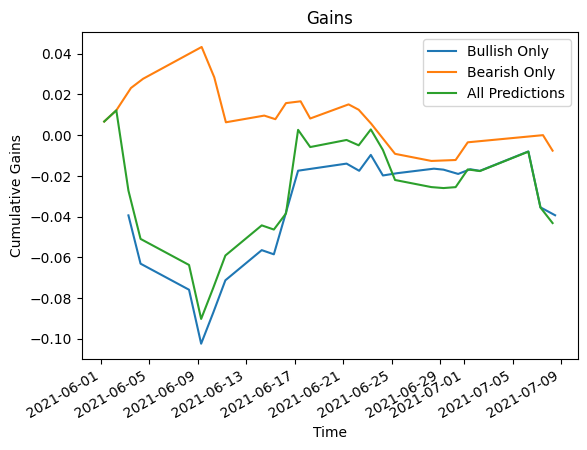

In [25]:
rf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=0)  # A
lr = LogisticRegression(random_state=0)

ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),
    ('classifier', clf)
])

params.update({
    'select_from_model__threshold': [
        '0.5 * mean', 'mean', '0.5 * median', 'median' 
    ],#SFMによってどの基準で特徴量を切り捨てるかを判断する
    'select_from_model__estimator':  [rf, lr]
})

print("Feature Selection (SFM) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True  # C
)

del params['select_from_model__threshold']
del params['select_from_model__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

RFE(再起的特徴量削減)を使った特徴量削減

Feature Selection (RFE) 


/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to -1.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/py

              precision    recall  f1-score   support

       False       0.48      0.71      0.57        72
        True       0.40      0.20      0.27        69

    accuracy                           0.46       141
   macro avg       0.44      0.46      0.42       141
weighted avg       0.44      0.46      0.42       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5, 'rfe__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'rfe__n_features_to_select': 0.8}
Overall took 300.93 seconds
% of time with profit: 0.000
Total Gains for bullish is -0.039
% of time with profit: 1.000
Total Gains for bearish is 0.028
% of time with profit: 0.115
Total Gains for all predictions is -0.007


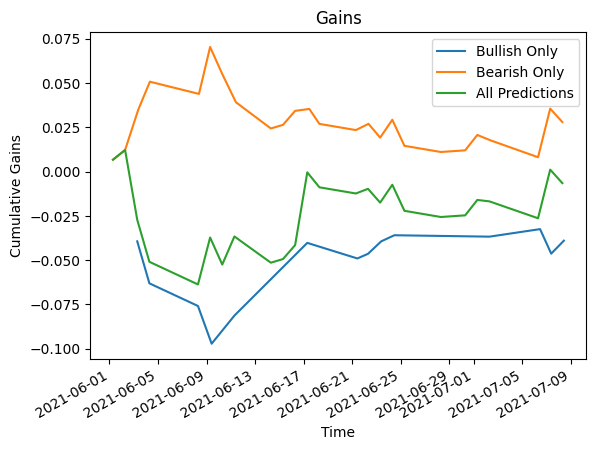

In [26]:
ml_pipeline = Pipeline([  
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=rf)),  #ランダムフォレストを用いてRFEで削減
    ('classifier', clf)
])

params.update({
    'rfe__n_features_to_select': [0.6, 0.7, 0.8, 0.9],
    'rfe__estimator':  [rf, lr]
})

print("Feature Selection (RFE) \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True
)
del params['rfe__n_features_to_select']
del params['rfe__estimator']

plot_gains(test_df.copy(), test_y, test_preds)

## 6. 特徴量抽出

多項式特徴量抽出

In [29]:
p = PolynomialFeatures(3) #以下の3つの特徴量を用いて全20個( =3H3)の多項式特徴量を作成
small_poly_features = p.fit_transform(
    data[['feature__rolling_close_mean_60',
    'feature__rolling_7_day_total_tweets', 
    'feature__morning']])

pd.DataFrame(small_poly_features, columns=p.get_feature_names_out())

,1,feature__rolling_close_mean_60,feature__rolling_7_day_total_tweets,feature__morning,feature__rolling_close_mean_60^2,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets,feature__rolling_close_mean_60 feature__morning,feature__rolling_7_day_total_tweets^2,feature__rolling_7_day_total_tweets feature__morning,feature__morning^2,feature__rolling_close_mean_60^3,feature__rolling_close_mean_60^2 feature__rolling_7_day_total_tweets,feature__rolling_close_mean_60^2 feature__morning,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets^2,feature__rolling_close_mean_60 feature__rolling_7_day_total_tweets feature__morning,feature__rolling_close_mean_60 feature__morning^2,feature__rolling_7_day_total_tweets^3,feature__rolling_7_day_total_tweets^2 feature__morning,feature__rolling_7_day_total_tweets feature__morning^2,feature__morning^3
0,1.0,108.297719,213.0,1.0,11728.396017,23067.414223,108.297719,45369.0,213.0,1.0,1.270159e+06,2.498148e+06,11728.396017,4.913359e+06,23067.414223,108.297719,9663597.0,45369.0,213.0,1.0
1,1.0,108.330916,213.0,1.0,11735.587280,23074.485028,108.330916,45369.0,213.0,1.0,1.271327e+06,2.499680e+06,11735.587280,4.914865e+06,23074.485028,108.330916,9663597.0,45369.0,213.0,1.0
2,1.0,108.358464,213.0,1.0,11741.556642,23080.352755,108.358464,45369.0,213.0,1.0,1.272297e+06,2.500952e+06,11741.556642,4.916115e+06,23080.352755,108.358464,9663597.0,45369.0,213.0,1.0
3,1.0,108.384685,213.0,1.0,11747.240006,23085.937968,108.384685,45369.0,213.0,1.0,1.273221e+06,2.502162e+06,11747.240006,4.917305e+06,23085.937968,108.384685,9663597.0,45369.0,213.0,1.0
4,1.0,108.405694,213.0,1.0,11751.794554,23090.412883,108.405694,45369.0,213.0,1.0,1.273961e+06,2.503132e+06,11751.794554,4.918258e+06,23090.412883,108.405694,9663597.0,45369.0,213.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113257,1.0,384.732251,361.0,0.0,148018.905101,138888.342677,0.000000,130321.0,0.0,0.0,5.694765e+07,5.343482e+07,0.000000,5.013869e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113258,1.0,384.714454,361.0,0.0,148005.211319,138881.917989,0.000000,130321.0,0.0,0.0,5.693974e+07,5.342988e+07,0.000000,5.013637e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113259,1.0,384.690810,361.0,0.0,147987.019194,138873.382361,0.000000,130321.0,0.0,0.0,5.692925e+07,5.342331e+07,0.000000,5.013329e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0
113260,1.0,384.676488,361.0,0.0,147976.000273,138868.212099,0.000000,130321.0,0.0,0.0,5.692289e+07,5.341934e+07,0.000000,5.013142e+07,0.000000,0.000000,47045881.0,0.0,0.0,0.0


作成した特徴量を用いてパイプライン(特徴量選択込み)を構成

Polynomial Features 


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

              precision    recall  f1-score   support

       False       0.49      0.68      0.57        72
        True       0.45      0.28      0.34        69

    accuracy                           0.48       141
   macro avg       0.47      0.48      0.46       141
weighted avg       0.47      0.48      0.46       141

Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': None, 'classifier__min_samples_split': 5, 'poly__degree': 2, 'select_from_model__estimator': RandomForestClassifier(n_estimators=20, random_state=0), 'select_from_model__threshold': 'mean'}
Overall took 1453.64 seconds
% of time with profit: 0.765
Total Gains for bullish is 0.054
% of time with profit: 1.000
Total Gains for bearish is 0.055
% of time with profit: 0.923
Total Gains for all predictions is 0.066


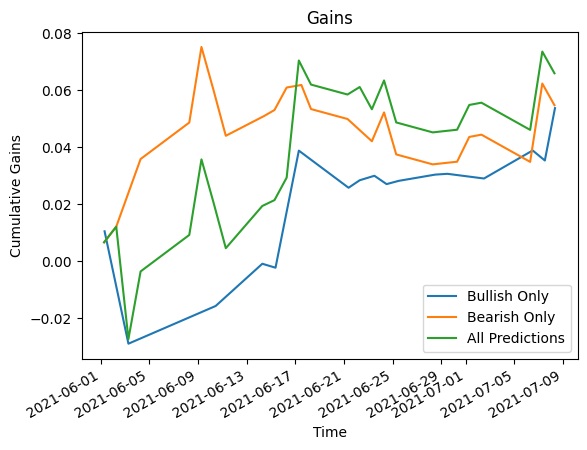

In [30]:
ml_pipeline = Pipeline([  
    ('poly', PolynomialFeatures(1, include_bias=False)),
    ('scale', StandardScaler()),
    ('select_from_model', SelectFromModel(estimator=rf)),  #SFMで特徴量選択
    ('classifier', clf)
])

params.update({
    'select_from_model__threshold': ['0.5 * mean', 'mean', '0.5 * median', 'median'],
    'select_from_model__estimator':  [rf, lr],
    'poly__degree': [2],
})

print("Polynomial Features \n==========================")
best_model, test_preds, test_probas = advanced_grid_search(
    train_X, train_y,
    test_X, test_y,
    ml_pipeline, params, 
    cv=tscv, include_probas=True 
)

del params['poly__degree']
del params['select_from_model__threshold']
del params['select_from_model__estimator']

plot_gains(test_df.copy(), test_y, test_preds)